In [1]:
import requests
import json
from datetime import datetime
import time
from requests.auth import HTTPBasicAuth
# from GrafanaPrometheusDataFetcher import GrafanaPrometheusDataFetcher

class GrafanaDashboardProcessor:
    def __init__(self, grafana_url, api_key, dashboard_uid, username, password, start_time_str, end_time_str):
        self.grafana_url = grafana_url
        self.api_key = api_key
        self.dashboard_uid = dashboard_uid
        self.username = username
        self.password = password
        
        # Convert human-readable dates to Unix timestamps
        self.start_time = self.convert_to_unix(start_time_str)
        self.end_time = self.convert_to_unix(end_time_str)
        
        # Store the processed data
        self.data = {}

    def convert_to_unix(self, time_str):
        return int(time.mktime(datetime.strptime(time_str, "%Y-%m-%d %H:%M:%S").timetuple()))

    def fetch_dashboard(self):
        dashboard_url = f"{self.grafana_url}/api/dashboards/uid/{self.dashboard_uid}"
        response = requests.get(dashboard_url, auth=HTTPBasicAuth(self.username, self.password))
        
        if response.status_code == 200:
            return response.json()
        else:
            response.raise_for_status()

    @staticmethod
    def extract_metric_name(expr):
        if "{" in expr:
            return expr.split("{")[0].strip()
        return expr.strip()

    def process_panels(self, dashboard_data):
        for panel in dashboard_data['dashboard']['panels']:
            panel_id = panel['id']
            panel_title = panel.get('title', 'Unnamed Panel')
            panel_type = panel.get('type', 'Unknown')

            for target in panel.get('targets', []):
                prom_query = target.get('expr', None)
                datasource_data = target.get('datasource', None)

                if prom_query and datasource_data:
                    uid = datasource_data['uid']
                    type_name = datasource_data['type']
                    metric_name = self.extract_metric_name(prom_query)

                    # Initialize the uid structure if it doesn't exist
                    if uid not in self.data:
                        self.data[uid] = {
                            "uid_details": {
                                "type_name": type_name,
                                "uid": uid
                            },
                            uid: {}
                        }

                    # Initialize the panel_type structure under the uid if it doesn't exist
                    if panel_type not in self.data[uid][uid]:
                        self.data[uid][uid][panel_type] = {
                            "expr_list": [],
                            "panels": []
                        }

                    # Append the metric name to expr_list
                    self.data[uid][uid][panel_type]["expr_list"].append(metric_name)

                    # Construct panel_info
                    panel_info = {
                        "id": panel_id,
                        "title": panel_title,
                        "datasource": datasource_data
                    }

                    # Append the panel_info under the appropriate panel_type
                    self.data[uid][uid][panel_type]["panels"].append(panel_info)
        return self.data

    @staticmethod
    def save_to_file(file_name, data):
        with open(file_name, 'w') as f:
            json.dump(data, f, indent=2)

    def run(self):
        dashboard_data = self.fetch_dashboard()
        self.process_panels(dashboard_data)
        self.save_to_file('datasource.json',self.data)
        print(json.dumps(self.data, indent=2))

In [2]:
import json
import pandas as pd
import requests
from requests.auth import HTTPBasicAuth
import matplotlib.pyplot as plt
from datetime import datetime

class GrafanaPrometheusDataFetcher:
    def __init__(self, url, username, password, query_url):
        self.url = url
        self.username = username
        self.password = password
        self.query_url = query_url
        
    def fetch_data(self, body):
        """Fetches data from the Prometheus API."""
        try:
            response = requests.post(self.query_url, auth=HTTPBasicAuth(self.username, self.password), json=body)
            response.raise_for_status()
            print("Data retrieved successfully")
            return response.json()
        except requests.exceptions.RequestException as e:
            print(f"Failed to retrieve data: {e}")
            return None
    
    def process_data(self, data, ref_id='A'):
        """Processes the JSON data and converts it into a Pandas DataFrame."""
        metrics = []
        for frame in data['results'][ref_id]['frames']:
            labels = frame['schema']['fields'][1]['labels']
            times = frame['data']['values'][0]
            values = frame['data']['values'][1]
            for t, v in zip(times, values):
                metrics.append({'Time': t, 'Value': v, **labels})
        df = pd.DataFrame(metrics)
        df['Time'] = pd.to_datetime(df['Time'], unit='ms')
        return df
    
    def plot_data(self, df, expr):
        """Plots the data from the DataFrame."""
        plt.figure(figsize=(10, 6))
        plt.plot(df['Time'], df['Value'], label=f'{expr} Rate', color='blue')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title(f'Time Series of {expr} Rate')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def build_query_body(self, expr, from_time, to_time, queries_type, uid):
        """Builds the query body for fetching data."""
        return {
            "queries": [
                {
                    "refId": "A",
                    "expr": f"rate({expr}[$__rate_interval])",
                    "range": True,
                    "datasource": {"type": queries_type, "uid": uid},
                    "intervalMs": 15000,
                    "maxDataPoints": 1539
                },
                {
                    "refId": "A-Instant",
                    "expr": f"rate({expr}[$__rate_interval])",
                    "instant": True,
                    "datasource": {"type": queries_type, "uid": uid},
                    "intervalMs": 15000,
                    "maxDataPoints": 1539
                }
            ],
            "from": from_time,
            "to": to_time
        }
    
    def get_resources(self, path):
        """Fetches available resources from the Prometheus API."""
        try:
            response = requests.get(f"{self.url}{path}", auth=HTTPBasicAuth(self.username, self.password))
            response.raise_for_status()
            return response.json().get('data', [])
        except requests.exceptions.RequestException as e:
            print(f"Failed to retrieve resources: {e}")
            return []
    
    @staticmethod
    def convert_to_timestamp(date_str):
        """Converts a date string to a Unix timestamp in milliseconds."""
        dt = datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")
        return str(int(dt.timestamp() * 1000))


Metric Names: ['calls_total', 'duration_milliseconds_bucket', 'duration_milliseconds_count', 'duration_milliseconds_sum', 'scrape_duration_seconds', 'scrape_samples_post_metric_relabeling', 'scrape_samples_scraped', 'scrape_series_added', 'target_info', 'up']
Data retrieved successfully


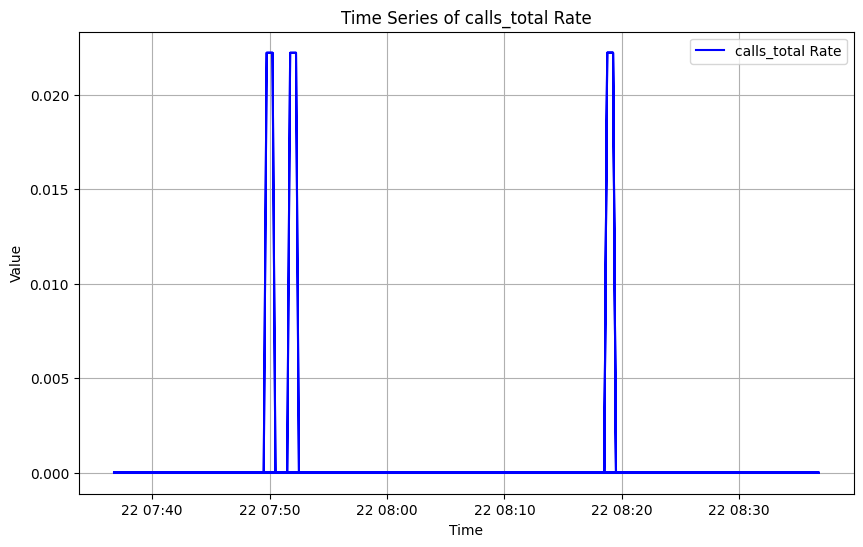

Data for calls_total:
Data retrieved successfully


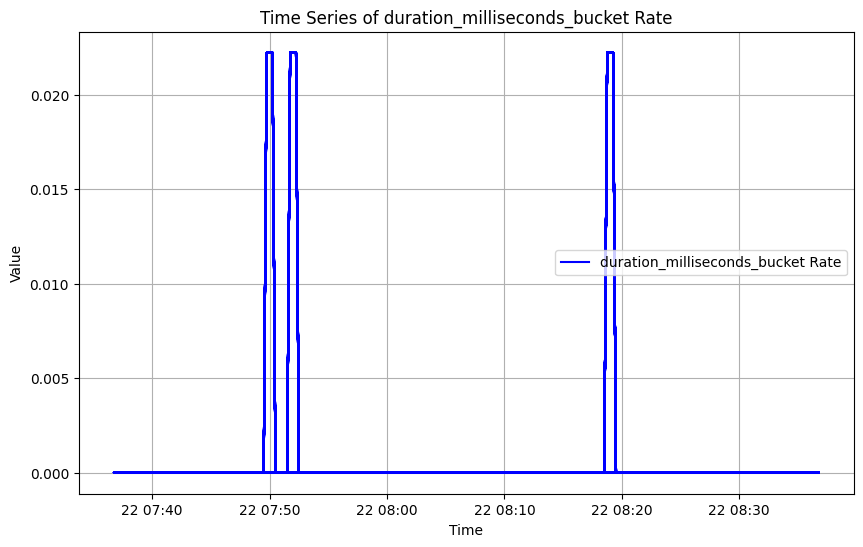

Data for duration_milliseconds_bucket:
Data retrieved successfully


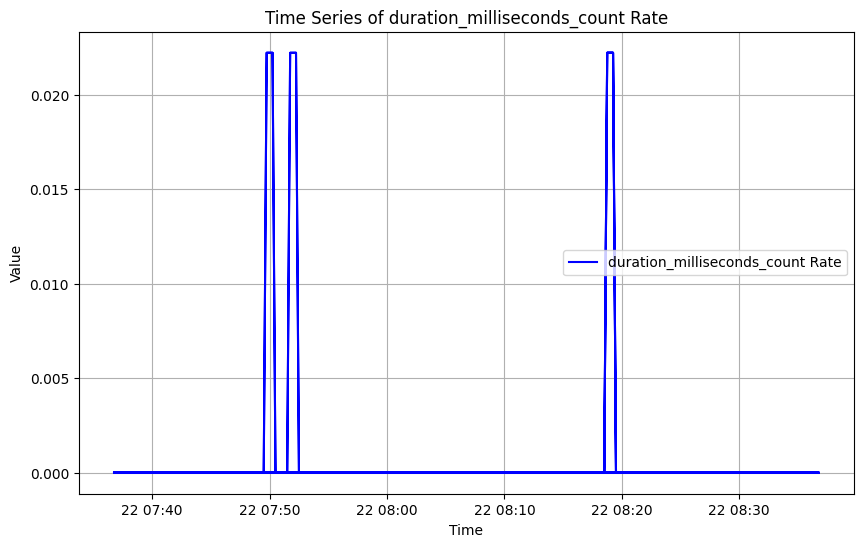

Data for duration_milliseconds_count:
Data retrieved successfully


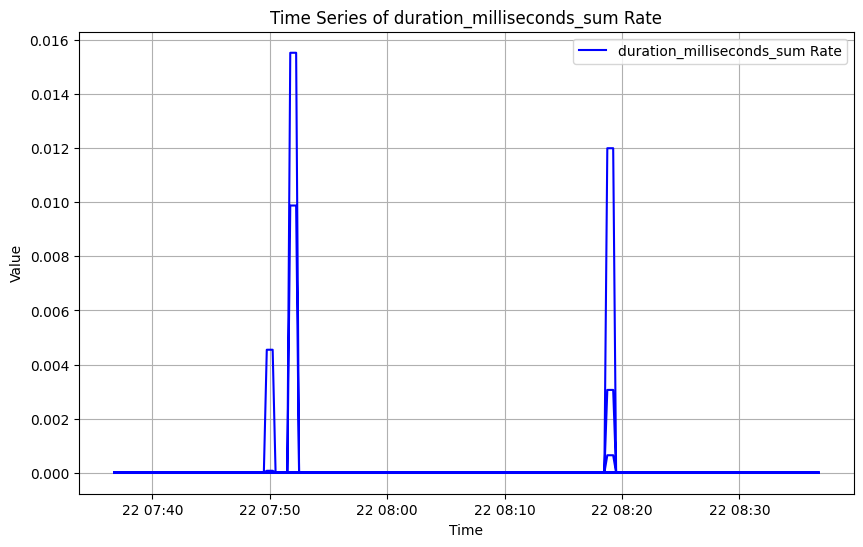

Data for duration_milliseconds_sum:
Data retrieved successfully


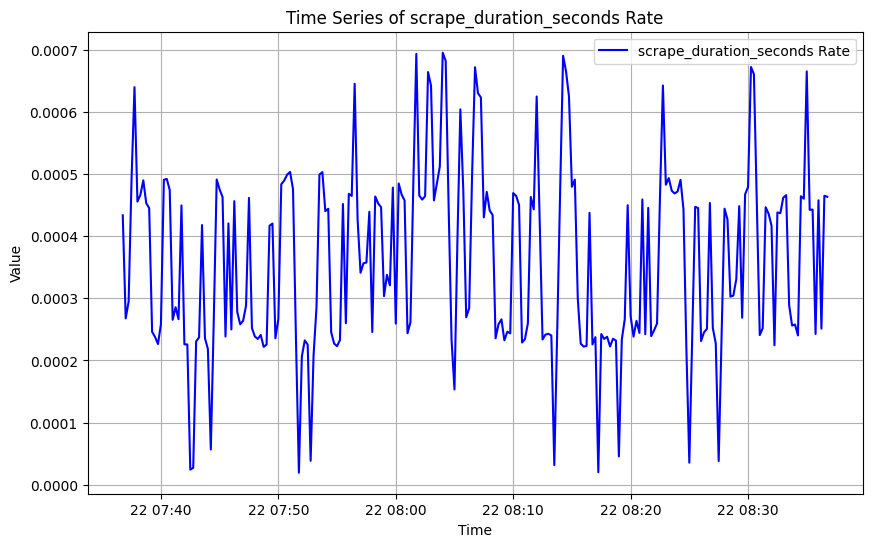

Data for scrape_duration_seconds:
Data retrieved successfully


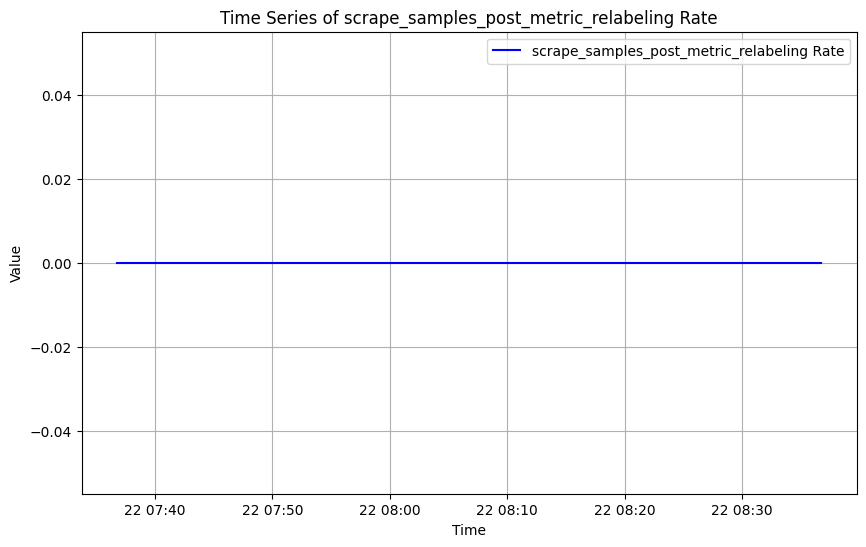

Data for scrape_samples_post_metric_relabeling:
Data retrieved successfully


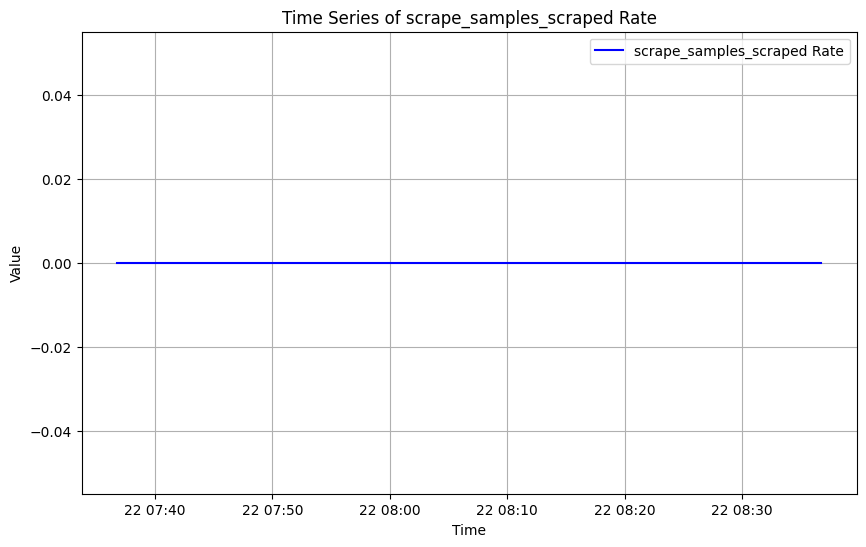

Data for scrape_samples_scraped:
Data retrieved successfully


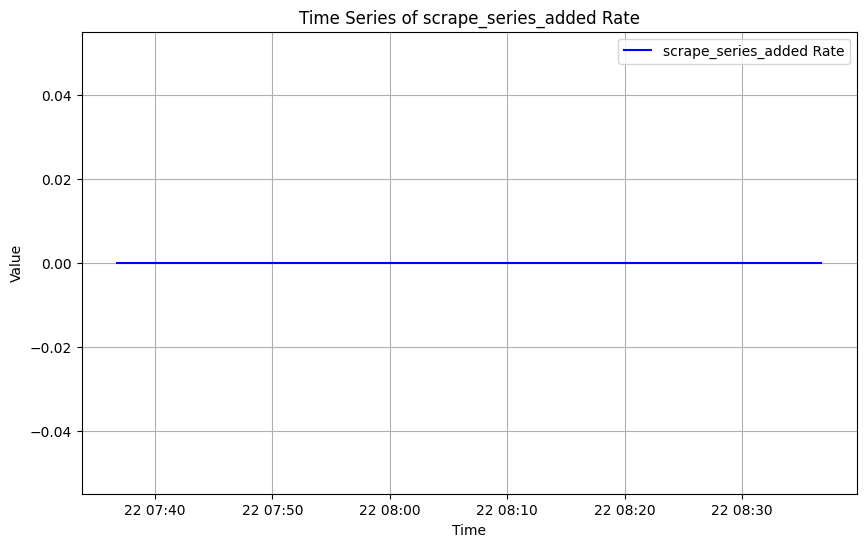

Data for scrape_series_added:
Data retrieved successfully


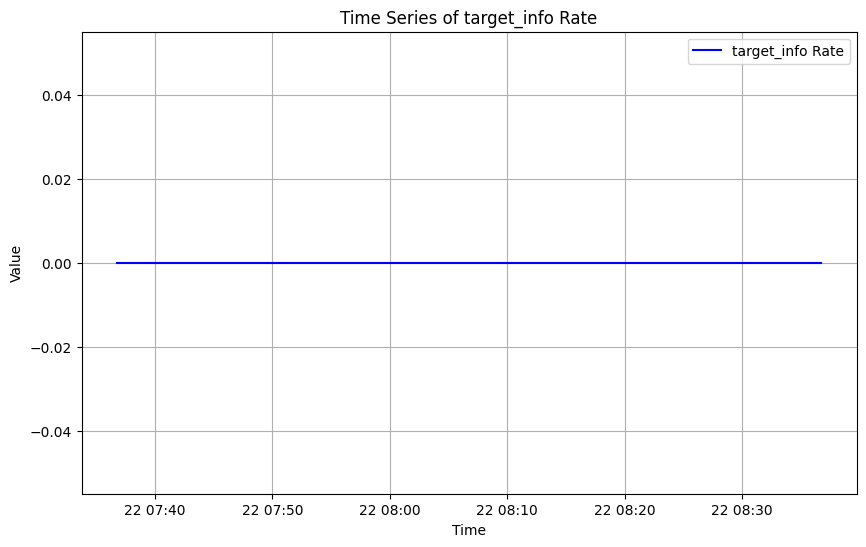

Data for target_info:
Data retrieved successfully


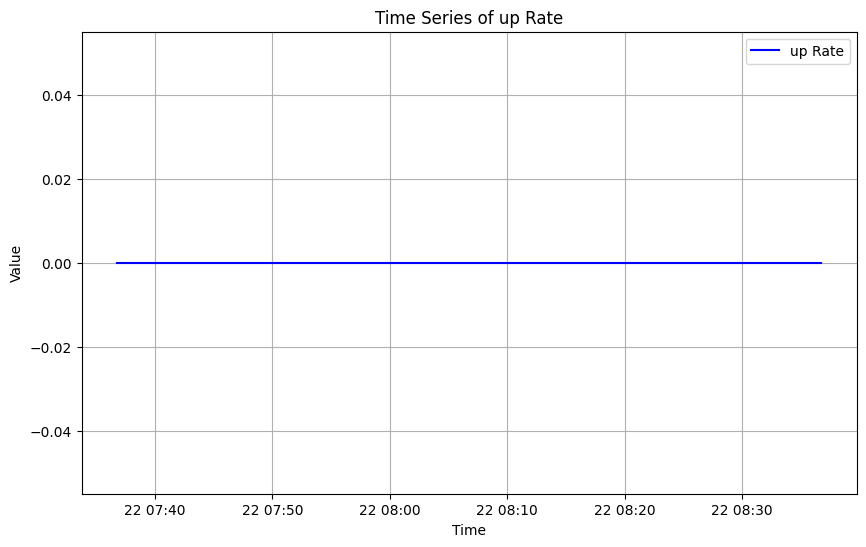

Data for up:
END


In [3]:
import os
import json
# from GrafanaPrometheusDataFetcher import GrafanaPrometheusDataFetcher
# from GrafanaDashboardProcessor import GrafanaDashboardProcessor

def main():
    # Define necessary parameters
    GRAFANA_URL = "https://op.cloudbuilders.io"
    API_KEY = "glsa_Y8WYTAWLM3BoHHDGYSUb86e59kbGkBIw_523e9ead"
    DASHBOARD_UID = "opentelemetry-apm"
    
    username = 'admin'
    password = 'Imfine123$'
    timeframes = ['2024-08-22 13:06:55', '2024-08-22 14:06:55']
    
    # Create an instance of the processor
    processor = GrafanaDashboardProcessor(
        grafana_url=GRAFANA_URL,
        api_key=API_KEY,
        dashboard_uid=DASHBOARD_UID,
        username=username,
        password=password,
        start_time_str=timeframes[0],
        end_time_str=timeframes[1]
    )
    
    # Fetch and process the dashboard data
    dashboard_data = processor.fetch_dashboard()
    data = processor.process_panels(dashboard_data)
    
    # Example usage of GrafanaPrometheusDataFetcher for fetching Prometheus data
    for uid in data:
        type_name = data[uid]['uid_details']['type_name']
        query_url = f"{GRAFANA_URL}/api/ds/query?ds_type={type_name}&requestId=explore_x25"
        fetcher = GrafanaPrometheusDataFetcher(GRAFANA_URL, username, password, query_url)
        
        from_time = fetcher.convert_to_timestamp(timeframes[0])
        to_time = fetcher.convert_to_timestamp(timeframes[1])
        
        # Path to get resource names (e.g., Prometheus metric names)
        path = f"/api/datasources/uid/{uid}/resources/api/v1/label/__name__/values?start=1724389980&end=1724393640"
        expr_list = fetcher.get_resources(path=path)
        
        print("Metric Names:", expr_list)
        
        # Initialize main_df as a dictionary to hold DataFrames for each expr
        main_df = {}
        output_dir_csv = 'output_csv'
        output_dir_json = 'output_json'
        
        # Ensure the output directory exists
        if not os.path.exists(output_dir_csv):
            os.makedirs(output_dir_csv)

         # Ensure the output directory exists
        if not os.path.exists(output_dir_json):
            os.makedirs(output_dir_json)
        
        # Loop through each metric and process data
        for expr in expr_list:
            body = fetcher.build_query_body(expr, from_time, to_time, type_name, uid)
            json_data = fetcher.fetch_data(body)
            
            if json_data:
                # Save the data to a file
                processor.save_to_file(f'{output_dir_json}/{expr}.json',json_data)
                
                
                # Process the data into a DataFrame
                df = fetcher.process_data(json_data)
                
                # Save the DataFrame to a CSV file for easier inspection
                df.to_csv(f'{output_dir_csv}/{expr}.csv', index=False)

                # Plot the data
                fetcher.plot_data(df, expr)
                
                # Initialize the key in main_df if it doesn't exist
                if expr not in main_df:
                    main_df[expr] = []
                
                # Append the DataFrame to the list for that metric
                main_df[expr].append(df)
                
                # Print the DataFrame (table format)
                print(f"Data for {expr}:")
                # print(df.to_string())  # This prints the entire DataFrame as a table
                # print(df.head())
        
        # Print the final main_df dictionary
        # print("""(((((((main_df)))))))""")
        # test=main_df['calls_total']
        # print(test)
        print("END")
        
main()
